In [1]:
import gym
#import random
import numpy as np
import matplotlib.pyplot as plt

#import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

#from tflearn.layers.core import input_data, dropout, fully_connected
#from tflearn.layers.estimator import regression
from statistics import median, mean
from collections import Counter

env = gym.make("CartPole-v0")
env.reset()
goal_steps = 500
score_requirement = 60
initial_games = 50000

# Execute Episodes - Generate Examples

In [2]:
def executeEpisode(model = None):
    ''' Generate and example episode of [4 x observation(t), action(t), E[return(t)]]. 
        All values are in a (n x 6) numpy array where n is the number of steps for the 
        episode to finish or the limit of 200 steps'''
    score = 0
    example = np.zeros((goal_steps, 6) )
    prev_observation = env.reset() # list of 4 elements

    # --------- ITERATE UP TO 500 STEPS PER EPISODE -------------
    for t in range(goal_steps):

        # --------- GENERATE ACTION ------------
        # We can generate random actions or actions from the previous policy (i.e. prev nnet)
        if model == None or t == 0:
            action = env.action_space.sample()   # choose random action (0-left or 1-right)
        else:
            x = torch.tensor(   prev_observation,   dtype = torch.float    )
            action_prob, e_score = model.forward(x)
            action = np.argmax(   action_prob.detach().numpy()   )                

        observation, reward, done, info = env.step(action)

        # --------- STORE STATE-ACTION PAIR + SCORE ------------
        example[t, 0:4] = prev_observation[0:4]
        example[t, 4:6] = [action, score]

        prev_observation = np.array(observation)
        score += reward    # +1 for every frame we haven't fallen
        
        if done: 
            break
    
    example[:, 5] = score - example[:, 5]    # Convert scores to E[return] 
    return example[0:int(score), :] # we only want to return the parts with actual values

In [3]:
def GenerateExamples(model = None):
    # [OBS, MOVES, SCORE]
    allExamples = []
    accepted_scores = []    # just the scores that met our threshold
    
    # --------------- ITERATE THROUGH 10000 EPISODE ------------------
    for _ in range(initial_games):
       
        exampleGame = executeEpisode()
        
        # --------- SAVE EXAMPLE (EPISODE) IF (SCORE > THRESHOLD) ----------
        # Note, it does not save the score! Therefore all episodes with score > threshold
        # are treated equally (not the best way of doing this!)
        if exampleGame[0, 5] >= score_requirement:
            
            accepted_scores = np.append(accepted_scores, exampleGame[0, 5])
            if len(allExamples) == 0:
                allExamples = exampleGame
            else:
                allExamples = np.vstack(   (allExamples, exampleGame)   )
    
                
    # -------- SAVE TRAINING DATA -------------
    #training_data_save = np.array(examples)
    #np.save('saved.npy',training_data_save)
    
    # -------- PRINT STATS ------------
    avg_mean, avg_median = np.mean(accepted_scores), np.median(accepted_scores)
    print('Average accepted score:', avg_mean)
    print('Median score for accepted scores:', avg_median)
    print(Counter(accepted_scores))
    print(len(accepted_scores))
    
    return allExamples, avg_mean, avg_median


In [4]:
#eg, mean, med = GenerateExamples()

# Create Model

In [5]:
# Training settings
batch_size = 64

class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        
        self.l1 = nn.Linear(4, 128)
        self.l2 = nn.Linear(128, 256)
        self.l3 = nn.Linear(256, 128)
        self.l4 = nn.Linear(128, 32)
        
        self.dp = nn.Dropout(p = 0.3)  # Suragnair used 0.3
        self.fc1 = nn.Linear(32, 2)    # want an action vector output: [log(prob right), log(prob left)]
        self.fc2 = nn.Linear(32, 1)    # Output the expected return

    def forward(self, obs):
        #in_size = x.size(0)
        x = F.relu(self.dp(self.l1(obs)))
        x = F.relu(self.dp(self.l2(x)))
        x = F.relu(self.dp(self.l3(x)))
        x = F.relu(self.dp(self.l4(x)))
        
        #x = x.view(in_size, -1)  # flatten the tensor
        a = self.fc1(self.dp(x))
        action_probs = F.log_softmax(a, dim = -1)    # choose the dimension such that we get something like 
                                          # [exp(-0.6723) +  exp(-0.7144)] = 1 for the output
        v = self.fc2(self.dp(x))  # get a linear value for the expected return
        return action_probs, v                      
    


model = Net()
optimizer = optim.Adam(model.parameters(), lr=0.005)

# Train Model

In [6]:
def train_model(epoch, examples):
    model.train()
    action_loss, value_loss, accuracy = [], [], []
    
    # ------------- CONVERT TO CORRECT DATA TYPE ----------------
    gpu = torch.device("cpu")
    allStates= torch.tensor(  examples[:, 0:4],  dtype = torch.float, device = gpu)       #reshapes into a (23002, 4) array
    allActions = torch.tensor(  examples[:, 4], dtype = torch.long, device = gpu)    #reshapes into a (23002, 2) array 
    allReturns = torch.tensor(  examples[:, 5],  dtype = torch.float, device = gpu) 
    
    # We should permute data before batching really. (X is a torch Variable)
    #permutation = torch.randperm(X.size()[0])

    
    for index in range(0, allStates.size()[0], batch_size):        

        # -------- GET BATCHES -----------
        #indices = permutation[i:i+batch_size]
        batch_idx = int(index / batch_size) + 1 #add one so stats print properly
        batch_states = allStates[index : index+batch_size] # torch.Size([64, 4])
        batch_actions = allActions[index : index+batch_size] # torch.Size([64])
        batch_returns = allReturns[index: index+batch_size] # torch.Size([64])

        # --------- TRAIN & BACKPROP ----------
        optimizer.zero_grad()
        pred_actions, state_value = model(batch_states) # torch.Size([64, 2]) and torch.Size([64, 1])
        
        a_loss = F.nll_loss(pred_actions, batch_actions)
        #print(pred_actions.detach(), batch_actions.detach(), a_loss.detach())
        # Suragnair uses tanh for state_values, but their values are E[win] = [-1, 1] where -1 = loss
        # Here we are using the length of time that we have been "up"
        v_loss = F.binary_cross_entropy(torch.sigmoid(state_value[:, 0]), torch.sigmoid(batch_returns))
        
        action_loss.append(a_loss)
        value_loss.append(v_loss)
        tot_loss = a_loss*100 + v_loss # pareto optimality?
        
        # Should try and get this to work with one hot!
        tot_loss.backward()
        optimizer.step()
                
        # --------- PRINT STATS --------------
        # Get array of predicted actions and compare with target actions to compute accuracy
        arg = torch.argmax(pred_actions, dim = 1)
        accuracy.append(  1 - (torch.abs(arg - batch_actions).sum().detach().numpy()) / batch_size    ) #counts the different ones
        
        print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f} \tAccuracy: {:.5f}'.format(
                epoch, 
                batch_idx * batch_size, 
                allStates.size()[0],
                100 * batch_idx * batch_size / allStates.size()[0], 
                tot_loss,
                accuracy[batch_idx - 1])
                  
             )

    return action_loss, value_loss, accuracy

In [7]:
training_data, avg_mean, avg_median = GenerateExamples()

Average accepted score: 70.59205776173285
Median score for accepted scores: 67.0
Counter({63.0: 71, 60.0: 61, 61.0: 61, 64.0: 53, 62.0: 53, 66.0: 47, 68.0: 43, 65.0: 42, 67.0: 35, 72.0: 29, 69.0: 29, 73.0: 28, 71.0: 28, 70.0: 28, 79.0: 17, 77.0: 16, 74.0: 16, 81.0: 14, 78.0: 13, 75.0: 13, 82.0: 11, 76.0: 11, 87.0: 10, 85.0: 10, 86.0: 9, 80.0: 9, 83.0: 8, 89.0: 6, 84.0: 5, 88.0: 5, 90.0: 5, 98.0: 4, 94.0: 4, 91.0: 4, 93.0: 4, 95.0: 3, 92.0: 3, 103.0: 3, 97.0: 3, 120.0: 2, 102.0: 2, 121.0: 2, 117.0: 2, 107.0: 1, 96.0: 1, 118.0: 1, 106.0: 1, 116.0: 1, 101.0: 1, 131.0: 1, 124.0: 1, 122.0: 1})
831


In [9]:
a_loss, v_loss, batch_acc = train_model(1, training_data)

Train Epoch: 1 [64/58662 (0%)]	Loss: 70.207764 	Accuracy: 0.43750
Train Epoch: 1 [128/58662 (0%)]	Loss: 70.560051 	Accuracy: 0.51562
Train Epoch: 1 [192/58662 (0%)]	Loss: 69.642471 	Accuracy: 0.51562
Train Epoch: 1 [256/58662 (0%)]	Loss: 69.749832 	Accuracy: 0.54688
Train Epoch: 1 [320/58662 (1%)]	Loss: 70.291946 	Accuracy: 0.51562
Train Epoch: 1 [384/58662 (1%)]	Loss: 68.257515 	Accuracy: 0.54688
Train Epoch: 1 [448/58662 (1%)]	Loss: 67.973846 	Accuracy: 0.62500
Train Epoch: 1 [512/58662 (1%)]	Loss: 69.805466 	Accuracy: 0.51562
Train Epoch: 1 [576/58662 (1%)]	Loss: 70.952942 	Accuracy: 0.54688
Train Epoch: 1 [640/58662 (1%)]	Loss: 67.714737 	Accuracy: 0.56250
Train Epoch: 1 [704/58662 (1%)]	Loss: 67.238785 	Accuracy: 0.54688
Train Epoch: 1 [768/58662 (1%)]	Loss: 71.846519 	Accuracy: 0.48438
Train Epoch: 1 [832/58662 (1%)]	Loss: 73.236061 	Accuracy: 0.48438
Train Epoch: 1 [896/58662 (2%)]	Loss: 72.773827 	Accuracy: 0.51562
Train Epoch: 1 [960/58662 (2%)]	Loss: 65.691963 	Accuracy: 0.68

Train Epoch: 1 [8640/58662 (15%)]	Loss: 67.359291 	Accuracy: 0.62500
Train Epoch: 1 [8704/58662 (15%)]	Loss: 63.692547 	Accuracy: 0.68750
Train Epoch: 1 [8768/58662 (15%)]	Loss: 66.280586 	Accuracy: 0.60938
Train Epoch: 1 [8832/58662 (15%)]	Loss: 75.962311 	Accuracy: 0.54688
Train Epoch: 1 [8896/58662 (15%)]	Loss: 68.398239 	Accuracy: 0.68750
Train Epoch: 1 [8960/58662 (15%)]	Loss: 65.939926 	Accuracy: 0.67188
Train Epoch: 1 [9024/58662 (15%)]	Loss: 70.407745 	Accuracy: 0.60938
Train Epoch: 1 [9088/58662 (15%)]	Loss: 72.971786 	Accuracy: 0.51562
Train Epoch: 1 [9152/58662 (16%)]	Loss: 66.501213 	Accuracy: 0.62500
Train Epoch: 1 [9216/58662 (16%)]	Loss: 67.188469 	Accuracy: 0.64062
Train Epoch: 1 [9280/58662 (16%)]	Loss: 67.573448 	Accuracy: 0.60938
Train Epoch: 1 [9344/58662 (16%)]	Loss: 60.935619 	Accuracy: 0.65625
Train Epoch: 1 [9408/58662 (16%)]	Loss: 65.630531 	Accuracy: 0.64062
Train Epoch: 1 [9472/58662 (16%)]	Loss: 69.395958 	Accuracy: 0.53125
Train Epoch: 1 [9536/58662 (16%)]	

Train Epoch: 1 [17408/58662 (30%)]	Loss: 64.197029 	Accuracy: 0.67188
Train Epoch: 1 [17472/58662 (30%)]	Loss: 69.415955 	Accuracy: 0.60938
Train Epoch: 1 [17536/58662 (30%)]	Loss: 66.464073 	Accuracy: 0.60938
Train Epoch: 1 [17600/58662 (30%)]	Loss: 69.035286 	Accuracy: 0.51562
Train Epoch: 1 [17664/58662 (30%)]	Loss: 64.795784 	Accuracy: 0.59375
Train Epoch: 1 [17728/58662 (30%)]	Loss: 65.113289 	Accuracy: 0.62500
Train Epoch: 1 [17792/58662 (30%)]	Loss: 65.623474 	Accuracy: 0.65625
Train Epoch: 1 [17856/58662 (30%)]	Loss: 67.041359 	Accuracy: 0.56250
Train Epoch: 1 [17920/58662 (31%)]	Loss: 68.485115 	Accuracy: 0.59375
Train Epoch: 1 [17984/58662 (31%)]	Loss: 68.129845 	Accuracy: 0.45312
Train Epoch: 1 [18048/58662 (31%)]	Loss: 68.372635 	Accuracy: 0.62500
Train Epoch: 1 [18112/58662 (31%)]	Loss: 70.051453 	Accuracy: 0.54688
Train Epoch: 1 [18176/58662 (31%)]	Loss: 66.410858 	Accuracy: 0.62500
Train Epoch: 1 [18240/58662 (31%)]	Loss: 69.729538 	Accuracy: 0.56250
Train Epoch: 1 [1830

Train Epoch: 1 [26240/58662 (45%)]	Loss: 68.262215 	Accuracy: 0.57812
Train Epoch: 1 [26304/58662 (45%)]	Loss: 74.481354 	Accuracy: 0.54688
Train Epoch: 1 [26368/58662 (45%)]	Loss: 70.854759 	Accuracy: 0.48438
Train Epoch: 1 [26432/58662 (45%)]	Loss: 67.218468 	Accuracy: 0.59375
Train Epoch: 1 [26496/58662 (45%)]	Loss: 66.003304 	Accuracy: 0.59375
Train Epoch: 1 [26560/58662 (45%)]	Loss: 63.927139 	Accuracy: 0.65625
Train Epoch: 1 [26624/58662 (45%)]	Loss: 66.170052 	Accuracy: 0.59375
Train Epoch: 1 [26688/58662 (45%)]	Loss: 68.431419 	Accuracy: 0.59375
Train Epoch: 1 [26752/58662 (46%)]	Loss: 68.379021 	Accuracy: 0.59375
Train Epoch: 1 [26816/58662 (46%)]	Loss: 67.490784 	Accuracy: 0.56250
Train Epoch: 1 [26880/58662 (46%)]	Loss: 65.970001 	Accuracy: 0.60938
Train Epoch: 1 [26944/58662 (46%)]	Loss: 66.449142 	Accuracy: 0.65625
Train Epoch: 1 [27008/58662 (46%)]	Loss: 69.789093 	Accuracy: 0.57812
Train Epoch: 1 [27072/58662 (46%)]	Loss: 65.888634 	Accuracy: 0.59375
Train Epoch: 1 [2713

Train Epoch: 1 [34816/58662 (59%)]	Loss: 66.476357 	Accuracy: 0.53125
Train Epoch: 1 [34880/58662 (59%)]	Loss: 62.545414 	Accuracy: 0.62500
Train Epoch: 1 [34944/58662 (60%)]	Loss: 73.812813 	Accuracy: 0.54688
Train Epoch: 1 [35008/58662 (60%)]	Loss: 64.052124 	Accuracy: 0.70312
Train Epoch: 1 [35072/58662 (60%)]	Loss: 66.632492 	Accuracy: 0.64062
Train Epoch: 1 [35136/58662 (60%)]	Loss: 66.784927 	Accuracy: 0.60938
Train Epoch: 1 [35200/58662 (60%)]	Loss: 67.667572 	Accuracy: 0.59375
Train Epoch: 1 [35264/58662 (60%)]	Loss: 68.248749 	Accuracy: 0.57812
Train Epoch: 1 [35328/58662 (60%)]	Loss: 66.191307 	Accuracy: 0.68750
Train Epoch: 1 [35392/58662 (60%)]	Loss: 69.117516 	Accuracy: 0.53125
Train Epoch: 1 [35456/58662 (60%)]	Loss: 66.017838 	Accuracy: 0.64062
Train Epoch: 1 [35520/58662 (61%)]	Loss: 65.292351 	Accuracy: 0.60938
Train Epoch: 1 [35584/58662 (61%)]	Loss: 65.905869 	Accuracy: 0.60938
Train Epoch: 1 [35648/58662 (61%)]	Loss: 65.819382 	Accuracy: 0.51562
Train Epoch: 1 [3571

Train Epoch: 1 [43328/58662 (74%)]	Loss: 66.701385 	Accuracy: 0.62500
Train Epoch: 1 [43392/58662 (74%)]	Loss: 73.616547 	Accuracy: 0.35938
Train Epoch: 1 [43456/58662 (74%)]	Loss: 63.974808 	Accuracy: 0.54688
Train Epoch: 1 [43520/58662 (74%)]	Loss: 66.224091 	Accuracy: 0.62500
Train Epoch: 1 [43584/58662 (74%)]	Loss: 63.639359 	Accuracy: 0.60938
Train Epoch: 1 [43648/58662 (74%)]	Loss: 63.871906 	Accuracy: 0.62500
Train Epoch: 1 [43712/58662 (75%)]	Loss: 65.309738 	Accuracy: 0.62500
Train Epoch: 1 [43776/58662 (75%)]	Loss: 62.546646 	Accuracy: 0.62500
Train Epoch: 1 [43840/58662 (75%)]	Loss: 67.484627 	Accuracy: 0.53125
Train Epoch: 1 [43904/58662 (75%)]	Loss: 67.585022 	Accuracy: 0.53125
Train Epoch: 1 [43968/58662 (75%)]	Loss: 68.785957 	Accuracy: 0.59375
Train Epoch: 1 [44032/58662 (75%)]	Loss: 67.946701 	Accuracy: 0.67188
Train Epoch: 1 [44096/58662 (75%)]	Loss: 69.168701 	Accuracy: 0.59375
Train Epoch: 1 [44160/58662 (75%)]	Loss: 72.905365 	Accuracy: 0.59375
Train Epoch: 1 [4422

Train Epoch: 1 [51648/58662 (88%)]	Loss: 67.104759 	Accuracy: 0.64062
Train Epoch: 1 [51712/58662 (88%)]	Loss: 66.152222 	Accuracy: 0.59375
Train Epoch: 1 [51776/58662 (88%)]	Loss: 66.240997 	Accuracy: 0.62500
Train Epoch: 1 [51840/58662 (88%)]	Loss: 69.530289 	Accuracy: 0.57812
Train Epoch: 1 [51904/58662 (88%)]	Loss: 66.480476 	Accuracy: 0.59375
Train Epoch: 1 [51968/58662 (89%)]	Loss: 65.508080 	Accuracy: 0.64062
Train Epoch: 1 [52032/58662 (89%)]	Loss: 68.060143 	Accuracy: 0.65625
Train Epoch: 1 [52096/58662 (89%)]	Loss: 67.777611 	Accuracy: 0.64062
Train Epoch: 1 [52160/58662 (89%)]	Loss: 64.552162 	Accuracy: 0.65625
Train Epoch: 1 [52224/58662 (89%)]	Loss: 65.592476 	Accuracy: 0.53125
Train Epoch: 1 [52288/58662 (89%)]	Loss: 66.359657 	Accuracy: 0.62500
Train Epoch: 1 [52352/58662 (89%)]	Loss: 68.353188 	Accuracy: 0.59375
Train Epoch: 1 [52416/58662 (89%)]	Loss: 66.807961 	Accuracy: 0.51562
Train Epoch: 1 [52480/58662 (89%)]	Loss: 67.523354 	Accuracy: 0.56250
Train Epoch: 1 [5254

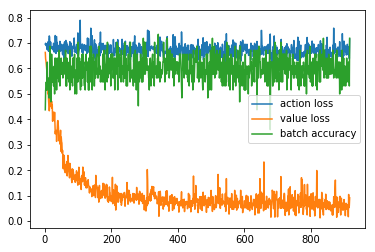

In [10]:
x = np.linspace(1, len(a_loss), num = len(a_loss))
plt.plot(x, a_loss)
plt.plot(x, v_loss)
plt.plot(x, batch_acc)
plt.legend(["action loss", "value loss", "batch accuracy"])
plt.show()

# Test the Model 

In [11]:
def test():
    
    model.eval()
    scores, expected_scores, choices = [], np.zeros(goal_steps), []
    
    # ------- PLAY SOME TEST GAMES ----------
    for each_game in range(50):
        env.reset()
        score, E_score = 0, []
        game_memory, prev_obs = [], []
        
        for _ in range(goal_steps):    # play up to (500) frames
            #env.render()
            
            # ----- GENERATE AN ACTION -------
            if len(prev_obs)==0:    # start by taking a random action
                action = env.action_space.sample()   
                
            else:                   # After that take the best predicted action by the neural net
                x = torch.tensor(   prev_obs,   dtype = torch.float    )
                action_prob, e_score = model.forward(x)
                action = np.argmax(   action_prob.detach().numpy()   )
                E_score.append(   np.array(e_score.detach())[0]   )  # see how the game updates it expected score as we move through

            new_observation, reward, done, info = env.step(action)
            prev_obs = new_observation
            
            # ----- RECORD RESULTS -------
            choices.append(action)   # just so we can work out the ratio of what we're predicting
            
            game_memory.append([new_observation, action])
            score += reward
            if done: break

        scores.append(score)    # Record the score of each game
        padding = np.zeros(int(goal_steps - score + 1), dtype = int)
        E_score = np.append([np.array(E_score)], [padding])
        expected_scores = np.vstack((expected_scores, E_score))

    print("Score Req: ", score_requirement)
    print('Average Score:',sum(scores)/len(scores))
    print('choice 1 (right): {:.4f}  choice 0 (left): {:.4f}'.format(choices.count(1)/len(choices),choices.count(0)/len(choices)))
    print(Counter(scores))
    
    return expected_scores

Score Req:  60
Average Score: 197.3
choice 1 (right): 0.5027  choice 0 (left): 0.4973
Counter({200.0: 47, 151.0: 1, 169.0: 1, 145.0: 1})


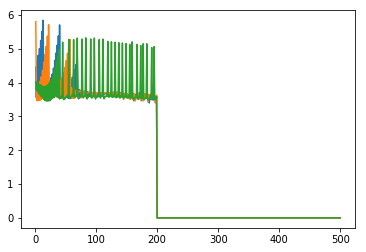

In [12]:
expected_scores = test()
x = np.linspace(1, len(expected_scores[0]), num = len(expected_scores[0]))
plt.plot(x, expected_scores[1])
plt.plot(x, expected_scores[6])
plt.plot(x, expected_scores[3])
plt.show()
